# Определение перспективного тарифа для телеком-компании 

Задача: сделать предварительный анализ тарифов на небольшой выборке клиентов, определить какой тариф экономически более выгоден.
На основе данных 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 
Описание тарифов
1. Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
                                          1. минута разговора: 3 рубля; 
                                          2. сообщение: 3 рубля;  
                                          3. 1 Гб интернет-трафика: 200 рублей.
2. Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
                                          1. минута разговора: 1 рубль;  
                                          2. сообщение: 1 рубль; 
                                          3. 1 Гб интернет-трафика: 150 рублей.

**Описание данных**

**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime

##  Изучение данных ##

In [2]:
other_date_paser = lambda x: datetime.strptime(x, "%Y-%m-%d")
users = pd.read_csv('/datasets/users.csv', parse_dates = ['reg_date'], date_parser = other_date_paser)
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Согласно описанию пропуски в churn_date значат, что тариф ещё действовал на момент выгрузки данных, не требуют заполнения. В других столбцах пропусков нет.

In [4]:
users.groupby('tariff').count()

,user_id,age,churn_date,city,first_name,last_name,reg_date
tariff,,,,,,,
smart,351,351,23,351,351,351,351
ultra,149,149,15,149,149,149,149


В датасете пользователи разделены по тарифам неравномерно: 351 пользователь в smart и 149 в ultra.

In [5]:
calls = pd.read_csv('/datasets/calls.csv', parse_dates = ['call_date'], date_parser = other_date_paser)
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Пропусков в данных нет.

In [7]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Минимальное значение в колонке продолжительность звонка 0, согласно описанию нулями обозначены пропущенные звонки, максимальное значение продолжительности 38 минут, что возможно с точки зрения реалистичности данных. Данные представлены по всем 500 пользователям с id от 1000 до 1499.

In [8]:
messages = pd.read_csv('/datasets/messages.csv',parse_dates = ['message_date'], date_parser = other_date_paser)
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Пропусков в данных нет.

In [10]:
internet = pd.read_csv('/datasets/internet.csv',index_col = 0,parse_dates = ['session_date'], date_parser = other_date_paser )
internet.head(5)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


Пропусков также нет, значения в столбце дата сессии в неподходящем формате. Есть дополнительгый столбец, дублирующий индекс строк.

In [12]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Описание условий тарифов.

### Вывод


В данных пропусков нет. 

Несоответствие типа данных значению столбца
* reg_date - object
* call_date -  object
* message_date - object
* session_date - object

Есть нулевые значения в столбце calls, являющиеся согласно описанию пропущенными звонками. Рассмотрим их подробнее на этапе предобработки данных, а также проверим столбец с длительностью интернет-сессий на нулевые значения.

## Предобработка данных

Этапы: 
    
1. Проверка на явные дуликаты
2. Нулевые значения

### Проверка на явные дуликаты

In [13]:
users.duplicated().sum()

0

In [14]:
calls.duplicated().sum()

0

In [15]:
messages.duplicated().sum()

0

In [16]:
internet.duplicated().sum()

0

### Нулевые значения

#### calls

В столбце calls есть звонки с нулевой продолжительностью, узнаем их долю.

In [17]:
round(len(calls.query('duration == 0'))*100/len(calls),1) ,'%'

(19.6, '%')

В описании к данным написано: "В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять".

Учитывая большую долю пропущенных звонков, хотя они не влияют на подсчет потраченных минут за месяц, но могут исказить расчетные значения среднего, в дальнейшем для расчетов будем использовать срез данных с продолжительностью звонка больше 0.

In [18]:
calls = calls.query('duration > 0').reset_index()

#### internet

In [19]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


В столбце с потраченными мегабайтами также есть нулевые значения, это ошибочные сессии, возможно связанные с проблемами сети, потерей сигнала из-за погодных условий или технических неполадок. Узнаем их долю.

In [20]:
round(len(internet.query('mb_used == 0'))*100/len(internet),1) ,'%'

(13.1, '%')

Доля таких "нулевых" сессий также велика, поэтому для предотвращения искажения рассчетных значений, в дальнейшем будем использовать срез данных с количеством потраченных мегабайт больше 0. 

In [21]:
internet = internet.query('mb_used > 0').reset_index()

## Расчёты и добавление результатов в таблицу

Рассчитаем для каждого пользователя для каждого пользователя по месяцам:
* количество сделанных звонков и израсходованных минут разговора 
* количество отправленных сообщений 
* объем израсходованного интернет-трафика 
* выручку 

Для этого сначала для каждого звонка, сообщения и сессии отметим месяц в отдельной колонке.

In [22]:
calls['month'] = calls['call_date'].dt.month
calls[['call_date', 'month']].head()

,call_date,month
0,2018-06-11,6
1,2018-09-21,9
2,2018-12-15,12
3,2018-08-22,8
4,2018-09-15,9


In [23]:
messages['month'] = messages['message_date'].dt.month
messages[['message_date', 'month']].head()

,message_date,month
0,2018-06-27,6
1,2018-10-08,10
2,2018-08-04,8
3,2018-06-16,6
4,2018-12-05,12


In [24]:
internet['month'] = internet['session_date'].dt.month
internet[['session_date', 'month']].head()

,session_date,month
0,2018-11-25,11
1,2018-09-07,9
2,2018-06-25,6
3,2018-08-22,8
4,2018-09-24,9


Теперь сгруппируем данные в каждой таблице по пользователю и месяцу.

### Количество сделанных звонков и израсходованных минут разговора

In [25]:
# перед подсчетом округлим длительность звонков к большему, согласно условиям тарифов
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head()

,index,id,call_date,duration,user_id,month
0,2,1000_2,2018-06-11,3.0,1000,6
1,3,1000_3,2018-09-21,14.0,1000,9
2,4,1000_4,2018-12-15,6.0,1000,12
3,7,1000_7,2018-08-22,19.0,1000,8
4,8,1000_8,2018-09-15,19.0,1000,9


In [26]:
#подсчитаем количество звонков и израсходованных минут
calls_by_month = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = {'count','sum'}).reset_index()
calls_by_month.head(10)

,user_id,month,count,sum
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0
5,1000,10,44,350.0
6,1000,11,37,338.0
7,1000,12,38,333.0
8,1001,11,45,430.0
9,1001,12,47,414.0


In [27]:
calls_by_month.count()

user_id    3168
month      3168
count      3168
sum        3168
dtype: int64

### Количество отправленных сообщений 

In [28]:
messages_by_month = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count').reset_index()
messages_by_month.head(10)

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [29]:
messages_by_month.count()

user_id    2717
month      2717
id         2717
dtype: int64

### Объем израсходованного интернет-трафика 

In [30]:
internet_by_month = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_by_month.head(10)

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


Объединим эти данные в одну таблицу

In [31]:
by_month = calls_by_month.merge(messages_by_month, on = ['user_id', 'month'], how = 'outer')
by_month = by_month.rename(columns = {'count':'calls', 'sum':'calls_duration', 'id':'messages'})
by_month.head()

,user_id,month,calls,calls_duration,messages
0,1000,5,17.0,159.0,22.0
1,1000,6,28.0,172.0,60.0
2,1000,7,41.0,340.0,75.0
3,1000,8,42.0,408.0,81.0
4,1000,9,46.0,466.0,57.0


In [32]:
by_month.isna().sum()

user_id             0
month               0
calls              44
calls_duration     44
messages          495
dtype: int64

После объединения таблиц появились пропуски, так в таблицах было разное количество строк.

In [33]:
by_month.count()

user_id           3212
month             3212
calls             3168
calls_duration    3168
messages          2717
dtype: int64

Все строчки из обеих таблиц на месте, данные не утеряны. Добавим данные по трафику по месяцам, а затем заменим все пропуски на 0, для удобства последующих вычислений.

In [34]:
by_month = by_month.merge(internet_by_month, on = ['user_id', 'month'], how = 'outer')
by_month.head()

,user_id,month,calls,calls_duration,messages,mb_used
0,1000,5,17.0,159.0,22.0,2253.49
1,1000,6,28.0,172.0,60.0,23233.77
2,1000,7,41.0,340.0,75.0,14003.64
3,1000,8,42.0,408.0,81.0,14055.93
4,1000,9,46.0,466.0,57.0,14568.91


In [35]:
by_month[['calls','calls_duration', 'messages', 'mb_used']] = by_month[['calls','calls_duration', 'messages', 'mb_used']].fillna(0)

In [36]:
by_month.isna().sum()

user_id           0
month             0
calls             0
calls_duration    0
messages          0
mb_used           0
dtype: int64

### Выручка

Для подсчета месячной выручки с каждого пользователя округлим количество потраченных минут и мегабайт в сторону большего, согласно условиям тарифов.

In [37]:
by_month['mb_used'] = by_month[ 'mb_used'].apply(np.ceil)
by_month.head()

,user_id,month,calls,calls_duration,messages,mb_used
0,1000,5,17.0,159.0,22.0,2254.0
1,1000,6,28.0,172.0,60.0,23234.0
2,1000,7,41.0,340.0,75.0,14004.0
3,1000,8,42.0,408.0,81.0,14056.0
4,1000,9,46.0,466.0,57.0,14569.0


Для подсчета выручки за месяц нужно знать какой тариф у каждого пользователя эта информация в таблице users.

In [38]:
by_month = by_month.merge(users[['user_id', 'tariff']], on = ['user_id'])
by_month.head(10)

,user_id,month,calls,calls_duration,messages,mb_used,tariff
0,1000,5,17.0,159.0,22.0,2254.0,ultra
1,1000,6,28.0,172.0,60.0,23234.0,ultra
2,1000,7,41.0,340.0,75.0,14004.0,ultra
3,1000,8,42.0,408.0,81.0,14056.0,ultra
4,1000,9,46.0,466.0,57.0,14569.0,ultra
5,1000,10,44.0,350.0,73.0,14703.0,ultra
6,1000,11,37.0,338.0,58.0,14757.0,ultra
7,1000,12,38.0,333.0,70.0,9818.0,ultra
8,1001,11,45.0,430.0,0.0,18430.0,smart
9,1001,12,47.0,414.0,0.0,14037.0,smart


In [39]:
# определим количество минут, потраченных сверх тарифа
def over_tariff(row):
    if row['tariff'] == 'ultra':
        over_tariff = row['calls_duration'] - 3000
    else:
        over_tariff = row['calls_duration'] - 500
    if over_tariff <= 0:
        return 0
    else:
        return over_tariff
by_month['call_over_tariff'] = by_month.apply(over_tariff, axis = 1)
by_month.head()

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff
0,1000,5,17.0,159.0,22.0,2254.0,ultra,0.0
1,1000,6,28.0,172.0,60.0,23234.0,ultra,0.0
2,1000,7,41.0,340.0,75.0,14004.0,ultra,0.0
3,1000,8,42.0,408.0,81.0,14056.0,ultra,0.0
4,1000,9,46.0,466.0,57.0,14569.0,ultra,0.0


In [40]:
by_month['call_over_tariff'].value_counts()

0.0      2460
32.0        9
41.0        7
18.0        7
44.0        7
         ... 
271.0       1
236.0       1
174.0       1
375.0       1
365.0       1
Name: call_over_tariff, Length: 291, dtype: int64

In [41]:
# определим количество сообщений, отправленных сверх тарифа
def over_tariff(row):
    if row['tariff'] == 'ultra':
        over_tariff = row['messages'] - 1000
    else:
        over_tariff = row['messages'] - 50
    if over_tariff <= 0:
        return 0
    else:
        return over_tariff
by_month['message_over_tariff'] = by_month.apply(over_tariff, axis = 1)
by_month.head()

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff,message_over_tariff
0,1000,5,17.0,159.0,22.0,2254.0,ultra,0.0,0.0
1,1000,6,28.0,172.0,60.0,23234.0,ultra,0.0,0.0
2,1000,7,41.0,340.0,75.0,14004.0,ultra,0.0,0.0
3,1000,8,42.0,408.0,81.0,14056.0,ultra,0.0,0.0
4,1000,9,46.0,466.0,57.0,14569.0,ultra,0.0,0.0


In [42]:
# определим количество мегабайт, потраченных сверх тарифа
def over_tariff(row):
    if row['tariff'] == 'ultra':
        over_tariff = row['mb_used'] - 30720
    else:
        over_tariff = row['mb_used'] - 15360
    if over_tariff <= 0:
        return 0
    else:
        return (over_tariff/1024)
by_month['mb_over_tariff'] = by_month.apply(over_tariff, axis = 1)
by_month.head()

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff,message_over_tariff,mb_over_tariff
0,1000,5,17.0,159.0,22.0,2254.0,ultra,0.0,0.0,0.0
1,1000,6,28.0,172.0,60.0,23234.0,ultra,0.0,0.0,0.0
2,1000,7,41.0,340.0,75.0,14004.0,ultra,0.0,0.0,0.0
3,1000,8,42.0,408.0,81.0,14056.0,ultra,0.0,0.0,0.0
4,1000,9,46.0,466.0,57.0,14569.0,ultra,0.0,0.0,0.0


In [43]:
by_month['mb_over_tariff'].value_counts()

0.000000    1776
0.158203       3
3.467773       3
2.548828       3
1.151367       2
            ... 
3.520508       1
3.552734       1
6.800781       1
2.264648       1
6.645508       1
Name: mb_over_tariff, Length: 1340, dtype: int64

In [44]:
# округлим трафик потраченный сверх тарифа в большую сторону, согласно условиям тарифа
by_month['mb_over_tariff'] = by_month['mb_over_tariff'].apply(np.ceil)
by_month['mb_over_tariff'].value_counts()

0.0     1776
2.0      204
1.0      186
3.0      168
4.0      168
5.0      150
7.0      124
6.0      122
8.0       81
9.0       59
10.0      57
12.0      31
11.0      30
13.0      24
14.0       8
16.0       7
15.0       6
20.0       3
17.0       3
21.0       2
19.0       2
18.0       1
22.0       1
23.0       1
Name: mb_over_tariff, dtype: int64

In [45]:
# напишем функцию для подсчета выручки за месяц, в 1 ГБ - 1024 МБ
def price_by_month(row):
    if row['tariff'] == 'ultra':
        price = 1950 + row['call_over_tariff']*1+ row['message_over_tariff']*1 + row['mb_over_tariff']*150
    else:
        price = 550 + row['call_over_tariff']*3+ row['message_over_tariff']*3 + row['mb_over_tariff']*200
    return price
by_month['price'] = by_month.apply(price_by_month, axis = 1)
by_month[['tariff', 'call_over_tariff', 'message_over_tariff', 'mb_over_tariff', 'price']].sample(10)

,tariff,call_over_tariff,message_over_tariff,mb_over_tariff,price
404,smart,0.0,0.0,4.0,1350.0
1608,ultra,0.0,0.0,0.0,1950.0
633,smart,44.0,0.0,0.0,682.0
1651,ultra,0.0,0.0,0.0,1950.0
2497,smart,0.0,0.0,0.0,550.0
1357,smart,67.0,0.0,2.0,1151.0
742,smart,0.0,0.0,7.0,1950.0
3018,ultra,0.0,0.0,12.0,3750.0
1451,smart,172.0,0.0,11.0,3266.0
2071,ultra,0.0,0.0,0.0,1950.0


### Вывод

В данные добавлены некоторые расчетные значения, которые позже будут использованы при проведении анализа.

## Статистический анализ данных

Изучим поведение клиентов оператора в группах пользователей различных тарифов.

### Smart

Выделим в отдельный датасет пользователей тарифа смарт и рассчитаем для каждого пользователя среднее значение расхода минут, сообщений и интернет-трафика.

In [46]:
total_stat_smart = by_month.query('tariff == "smart"')
total_stat_smart.head()

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff,message_over_tariff,mb_over_tariff,price
8,1001,11,45.0,430.0,0.0,18430.0,smart,0.0,0.0,3.0,1150.0
9,1001,12,47.0,414.0,0.0,14037.0,smart,0.0,0.0,0.0,550.0
10,1002,6,14.0,117.0,4.0,10857.0,smart,0.0,0.0,0.0,550.0
11,1002,7,21.0,214.0,11.0,17581.0,smart,0.0,0.0,3.0,1150.0
12,1002,8,37.0,289.0,13.0,20320.0,smart,0.0,0.0,5.0,1550.0


#### calls_duration

<function matplotlib.pyplot.show(*args, **kw)>

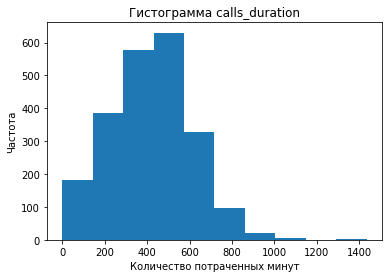

In [47]:
total_stat_smart['calls_duration'].plot(kind = 'hist')
plt.xlabel('Количество потраченных минут')
plt.ylabel('Частота')
plt.title('Гистограмма calls_duration')
plt.show

По гистограмме распределение близко к нормальному, с усечением отрицательного хвоста на 0.

((0, 900), <matplotlib.axes._subplots.AxesSubplot at 0x7f552077a890>)

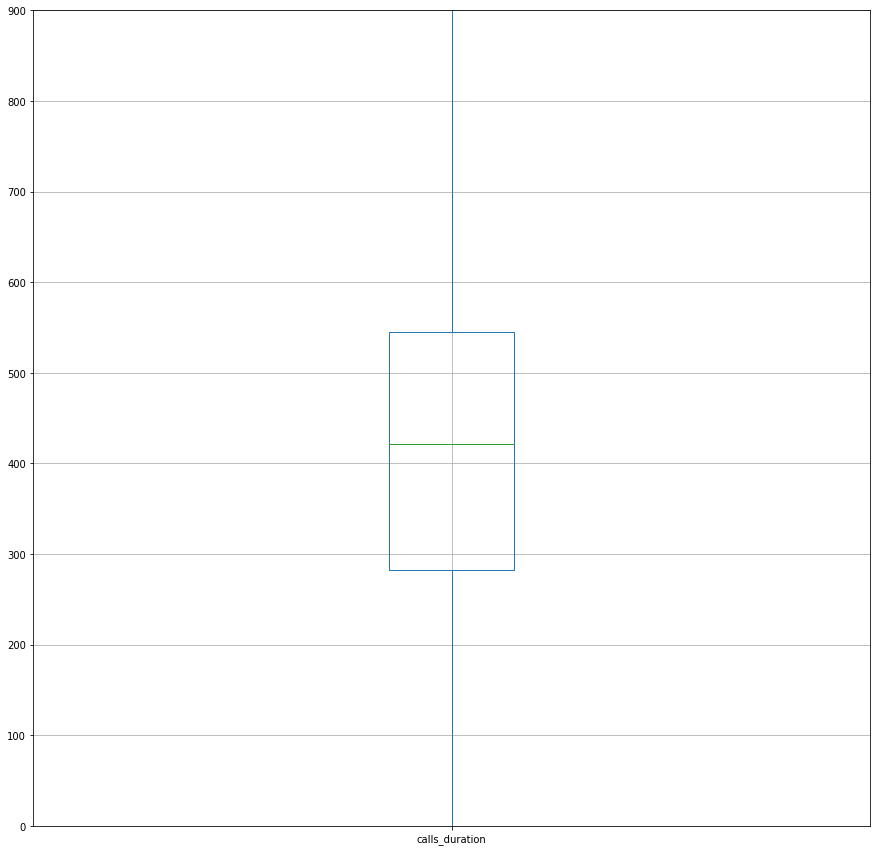

In [48]:
databox = total_stat_smart.boxplot('calls_duration', figsize = (15,15))
plt.ylim(0,900), databox

Согласно графику медиана около 420 минут, визуально медиана сдвинута в сторону больших значений. 

Также на графике видно, что границы первого квартиля находится в рамках лимита  по тарифу (до 500 минут), но третий квартиль дальше этой отметки, что свидетельствует о значимой доле пользователей (более 25%), превышающих лимит тарифа по минутам. Проверим расчетами.

In [49]:
# рассчитаем среднее
round(total_stat_smart['calls_duration'].mean(), 2)

417.93

In [50]:
# рассчитаем медиану
round(total_stat_smart['calls_duration'].median(), 2)

422.0

Медиана и среднее практически равны, что подтверждает нормальный характер распределения.

In [51]:
# посчитаем долю пользователей, которые превышают лимит минут, заложенных в тарифе
print('Доля пользователей, превышающих лимит минут:',\
      round(len(total_stat_smart.query('calls_duration > 500'))*100/len(total_stat_smart),1) ,'%')

Доля пользователей, превышающих лимит минут: 33.8 %


In [52]:
# рассчитаем дисперсию и стандартное отклонение
variance = np.var(total_stat_smart['calls_duration'])
f'Дисперсия: {variance:.2f}, Стандартное отклонение: {np.sqrt(variance):.2f}'

'Дисперсия: 36203.07, Стандартное отклонение: 190.27'

Учитывая нормальность распределения, согласно правилу трех сигм правктически все значения лежат в интервале 417.93 ± 570.81 (от 0 до 808 минут). Проверим.

In [53]:
print(round(len(total_stat_smart.query('calls_duration > 989'))*100/len(total_stat_smart),1), '%')

0.3 %


Типичный пользователь данной выборки (около 68%) тратит 417.93 ± 190.27 минут (от 227.66 до 608.2 минут), то есть больше половины отведенного тарифом лимита. Проверим.

In [54]:
print(round(len(total_stat_smart.query('calls_duration >= 228 and calls_duration <= 609 '))*100/len(total_stat_smart),1), '%')

68.1 %


#### messages

<function matplotlib.pyplot.show(*args, **kw)>

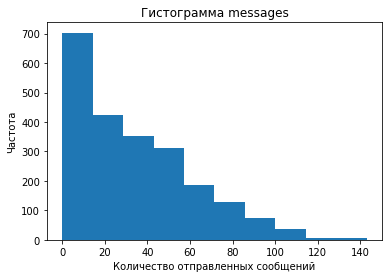

In [55]:
total_stat_smart['messages'].plot(kind = 'hist')
plt.xlabel('Количество отправленных сообщений')
plt.ylabel('Частота')
plt.title('Гистограмма messages')
plt.show

В целом распределение походит на усеченное нормальное распределение с усечением отрицательного хвоста.

((0, 120), <matplotlib.axes._subplots.AxesSubplot at 0x7f5520612410>)

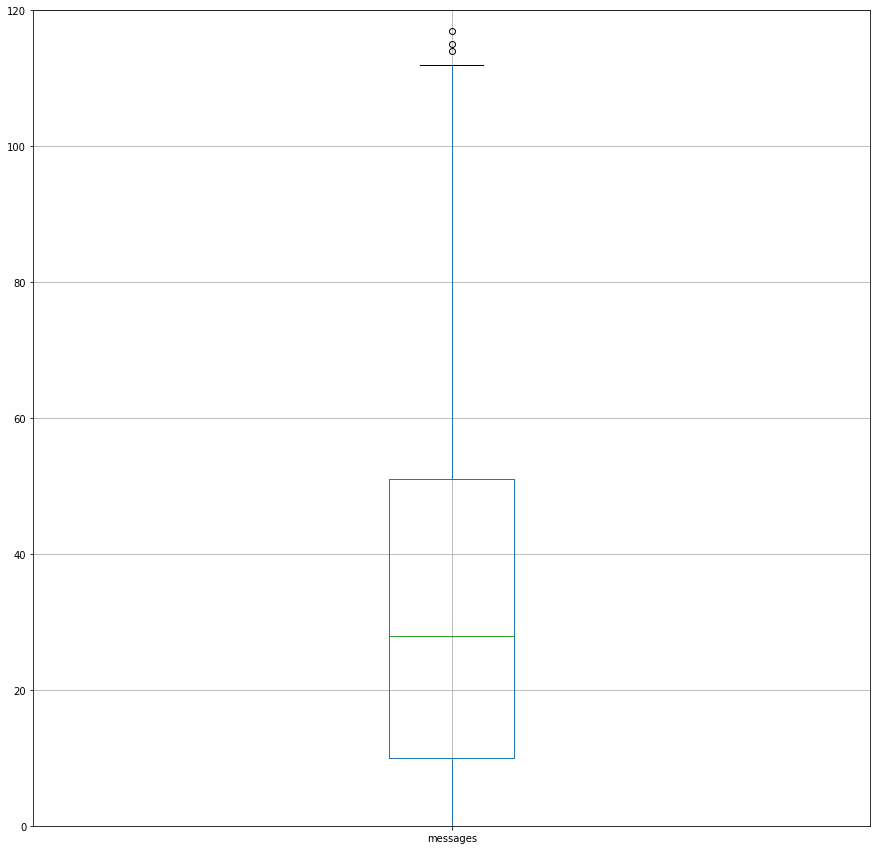

In [56]:
databox = total_stat_smart.boxplot('messages', figsize = (15,15))
plt.ylim(0,120), databox

Согласно графику медиана около 27 сообщений, визуально медиана сдвинута в сторону меньших значений. 

Также на графике видно, что границы первый квартиль находится в рамках лимита  по тарифу (до 50 сообщений), но третий квартиль визуально выше этой отметки, что свидетельствует о значимой доле пользователей (около 25%), превышающих лимит тарифа по сообщениям. Проверим расчетами.

In [57]:
# рассчитаем среднее
round(total_stat_smart['messages'].mean(), 2)

33.38

In [58]:
# рассчитаем медиану
round(total_stat_smart['messages'].median(), 2)

28.0

Медиана и среднее практически равны, среднее несколько сдвинуто относительно медианы в сторону больших значений.

In [59]:
# посчитаем долю пользователей, которые превышают лимит сообщений, заложенных в тарифе
print('Доля пользователей, превышающих лимит сообщений:',\
      round(len(total_stat_smart.query('messages > 50'))*100/len(total_stat_smart),1) ,'%')

Доля пользователей, превышающих лимит сообщений: 25.3 %


In [60]:
# рассчитаем дисперсию и стандартное отклонение
variance = np.var(total_stat_smart['messages'])
f'Дисперсия: {variance:.2f}, Стандартное отклонение: {np.sqrt(variance):.2f}'

'Дисперсия: 796.46, Стандартное отклонение: 28.22'

Типичный пользователь данной выборки в месяц отправляет 33.38 ± 28.22 сообщений (от 5.16 до 61.6 сообщений). Проверим.

In [61]:
print(round(len(total_stat_smart.query('messages >= 5 and messages <= 62 '))*100/len(total_stat_smart),1), '%')

65.3 %


#### internet

<function matplotlib.pyplot.show(*args, **kw)>

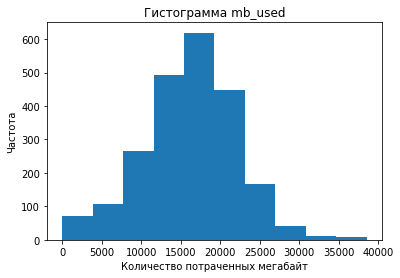

In [62]:
total_stat_smart['mb_used'].plot(kind = 'hist')
plt.xlabel('Количество потраченных мегабайт')
plt.ylabel('Частота')
plt.title('Гистограмма mb_used')
plt.show

Визуально распределение напоминает нормальное.

((5000, 25000), <matplotlib.axes._subplots.AxesSubplot at 0x7f551fdfeed0>)

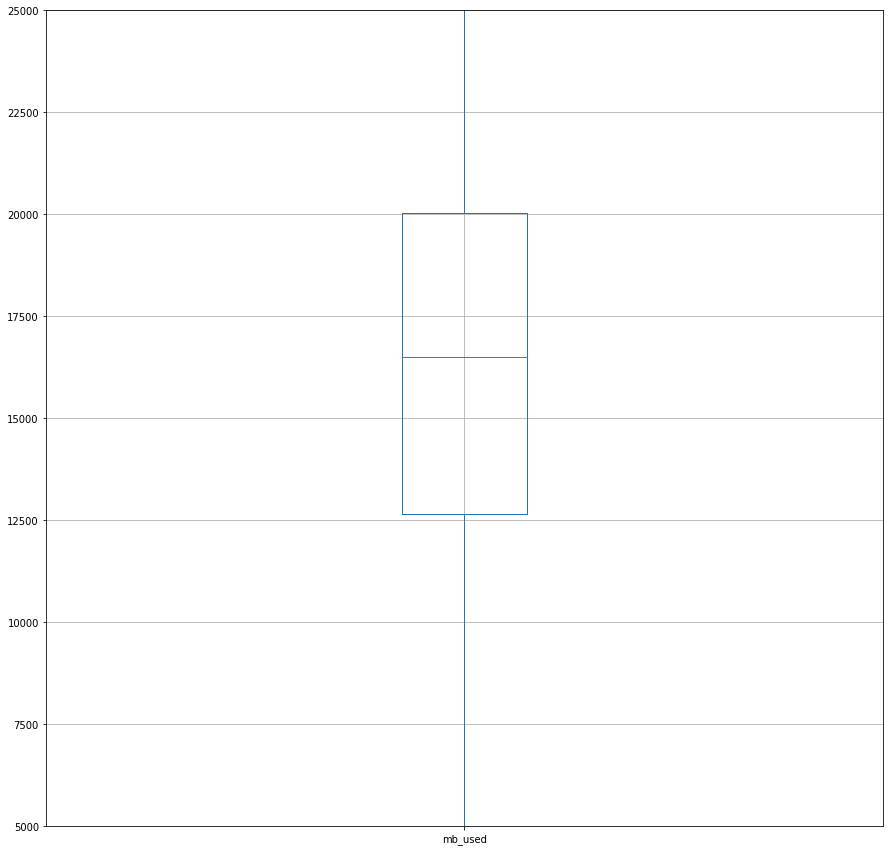

In [63]:
databox = total_stat_smart.boxplot('mb_used', figsize = (15,15))
plt.ylim(5000,25000), databox

Визуально медиана около 16250 МБ, что превышает лимит по тарифу. 

Также на графике видно, что граница третьего квартиля превышает лимита  по тарифу (до 15360 МБ), а первый квартиль близок к этой отметке, что свидетельствует о довольно большой доле пользователей, превышающих лимит тарифа по МБ. Проверим расчетами.

In [64]:
# рассчитаем среднее
round(total_stat_smart['mb_used'].mean(), 2)

16208.87

In [65]:
# рассчитаем медиану
round(total_stat_smart['mb_used'].median(), 2)

16507.0

Медиана и среднее практически равны, что подтверждает нормальный характер распределения.

In [66]:
# посчитаем долю пользователей, которые превышают лимит МБ, заложенных в тарифе
print('Доля пользователей, превышающих лимит мегабайт:',\
      round(len(total_stat_smart.query('mb_used > 15360'))*100/len(total_stat_smart),1) ,'%')

Доля пользователей, превышающих лимит мегабайт: 58.5 %


In [67]:
# рассчитаем дисперсию и стандартное отклонение
variance = np.var(total_stat_smart['mb_used'])
f'Дисперсия: {variance:.2f}, Стандартное отклонение: {np.sqrt(variance):.2f}'

'Дисперсия: 34447101.81, Стандартное отклонение: 5869.17'

Учитывая нормальность распределения, типичный пользователь данной выборки (около 68%) тратит 16208.87 ± 5869.17 МБ (от 10339.7 до 22078.04 МБ). Проверим.

In [68]:
print(round(len(total_stat_smart.query('mb_used >= 10400 and mb_used <= 22079 '))*100/len(total_stat_smart),1), '%')

71.4 %


Согласно данным представленной выборки **пользователям тарифа smart в месяц** требуется:

* **417.93 минут** (± 190.27)   
* **33.38 сообщений** (± 28.22)  
* **16208.87 МБ** (± 5869.17)


### Ultra

Выделим в отдельный датасет пользователей тарифа ультра.

In [69]:
total_stat_ultra = by_month.query('tariff == "ultra"')
total_stat_ultra.head()

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff,message_over_tariff,mb_over_tariff,price
0,1000,5,17.0,159.0,22.0,2254.0,ultra,0.0,0.0,0.0,1950.0
1,1000,6,28.0,172.0,60.0,23234.0,ultra,0.0,0.0,0.0,1950.0
2,1000,7,41.0,340.0,75.0,14004.0,ultra,0.0,0.0,0.0,1950.0
3,1000,8,42.0,408.0,81.0,14056.0,ultra,0.0,0.0,0.0,1950.0
4,1000,9,46.0,466.0,57.0,14569.0,ultra,0.0,0.0,0.0,1950.0


#### calls_duration

<function matplotlib.pyplot.show(*args, **kw)>

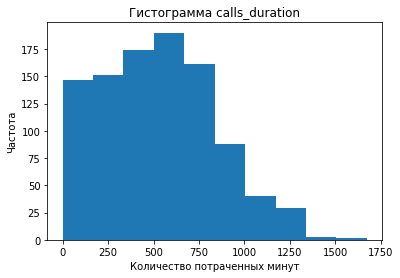

In [70]:
total_stat_ultra['calls_duration'].plot(kind = 'hist')
plt.xlabel('Количество потраченных минут')
plt.ylabel('Частота')
plt.title('Гистограмма calls_duration')
plt.show

Визуально по гистограмме слоно определить характер распределения, но прослеживается скошенность в сторону меньших значений.

((0, 1500), <matplotlib.axes._subplots.AxesSubplot at 0x7f551eee1a50>)

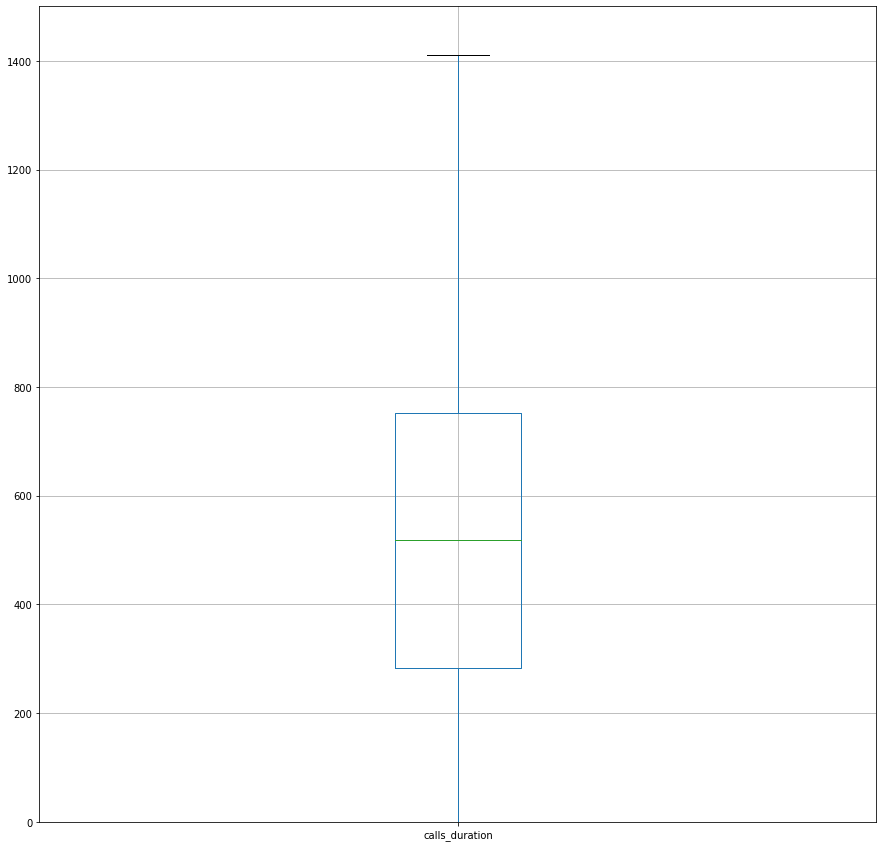

In [71]:
databox = total_stat_ultra.boxplot('calls_duration', figsize = (15,15))
plt.ylim(0,1500), databox

Согласно диаграмме размаха медиана около 520 минут, смещена в сторону меньших значений.

Границы межквартильного размаха около 290 - 750 минут, что гораздо меньше установленного лимита в 3000 минут, даже граница верхнего уса (1,5 межквартильный размах) около 1400 минут, что все ещё значимо меньше лимита. 
Согласно диаграмме, пользователей, превысивших лимит тарифа по минутам, нет.

In [72]:
# рассчитаем среднее
print('Среднее:',round(total_stat_ultra['calls_duration'].mean(), 2))

Среднее: 526.62


In [73]:
# рассчитаем медиану
print('Медиана:',round(total_stat_ultra['calls_duration'].median(), 2))

Медиана: 518.0


Среднее несколько смещено в сторону больших значений, возможно есть "выбивающиеся" большие значения, перетягивающие среднее на себя.

In [74]:
# посчитаем долю пользователей, которые превышают лимит минут, заложенных в тарифе
print('Доля пользователей, превышающих лимит минут:',\
      round(len(total_stat_ultra.query('calls_duration > 3000'))*100/len(total_stat_ultra),1) ,'%')

Доля пользователей, превышающих лимит минут: 0.0 %


Никто из пользователей выборки не превысил лимит тарифа по минутам. 

Проверим, есть ли значения более 1410 минут, не попавшие на диаграмму.

In [75]:
print(round(len(total_stat_ultra.query('calls_duration > 1410'))*100/len(total_stat_ultra),1) ,'%')

0.2 %


В выборке есть небольшая доля "нетипично" больших значений, перетягивающих среднее.

In [76]:
# рассчитаем дисперсию и стандартное отклонение
variance = np.var(total_stat_ultra['calls_duration'])
f'Дисперсия: {variance:.2f}, Стандартное отклонение: {np.sqrt(variance):.2f}'

'Дисперсия: 100771.22, Стандартное отклонение: 317.44'

Типичный пользователь данной выборки тратит 526.62 ± 317.44 минут (от 209.18 до 844.06 минут), что гораздо меньше отведенного тарифом лимита. Проверим.

In [77]:
print(round(len(total_stat_ultra.query('calls_duration >= 210 and calls_duration <= 845 '))*100/len(total_stat_ultra),1), '%')

66.9 %


#### messages

<function matplotlib.pyplot.show(*args, **kw)>

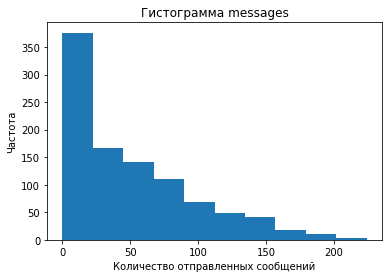

In [78]:
total_stat_ultra['messages'].plot(kind = 'hist')
plt.xlabel('Количество отправленных сообщений')
plt.ylabel('Частота')
plt.title('Гистограмма messages')
plt.show

Распределение напоминает нормальное с усеченным на 0 отрицательным хвостом, и "удлиненным" положительным хвостом.

((0, 200), <matplotlib.axes._subplots.AxesSubplot at 0x7f55166535d0>)

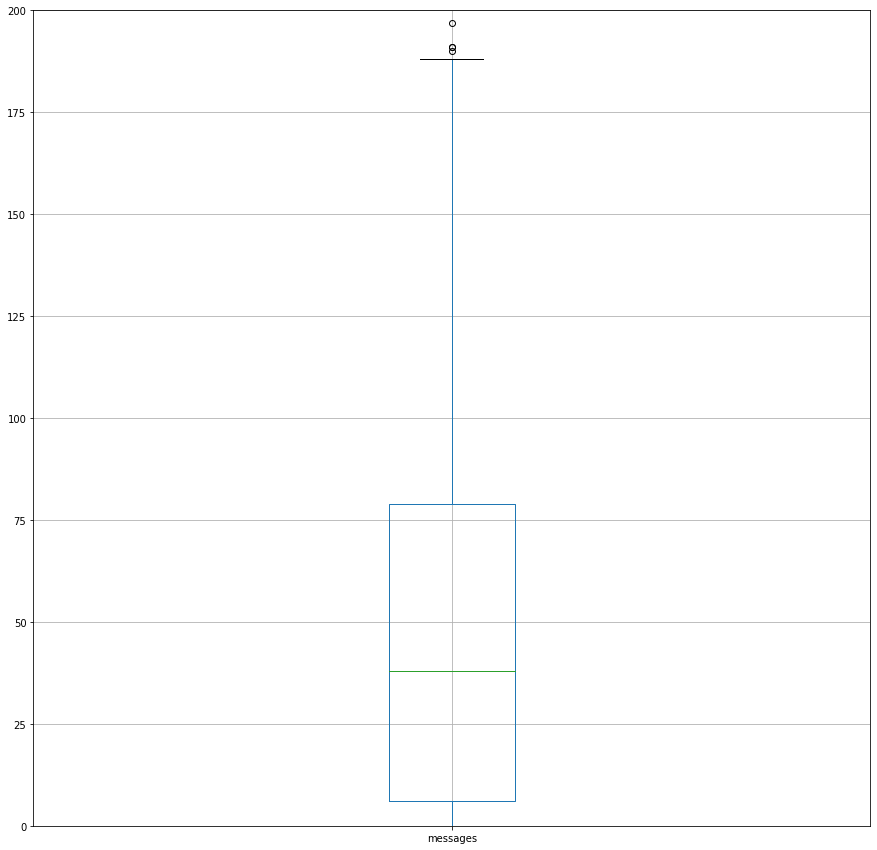

In [79]:
databox = total_stat_ultra.boxplot('messages', figsize = (15,15))
plt.ylim(0,200), databox

Согласно графику медиана около 38 сообщений, визуально медиана сдвинута в сторону меньших значений.

Также на графике видно, что границы первого и третьего квартилей (межквартильный размах) находятся в рамках лимита по тарифу (до 1000 сообщений),причем значительно меньше его, даже верхняя граница верхнего уса 188, значительно меньше лимита. Проверим расчетами.

In [80]:
# рассчитаем среднее
print('Среднее:',round(total_stat_ultra['messages'].mean(), 2))

Среднее: 49.36


In [81]:
# рассчитаем медиану
print('Медиана:',round(total_stat_ultra['messages'].median(), 2))

Медиана: 38.0


Среднее смещено относительно медианы в сторону больших значений, вероятно имеются "нетипично" большие для выборки значения.



In [82]:
# проверим отсутствие пользователей, которые превышают лимит сообщений, заложенных в тарифе
print('Доля пользователей, превышающих лимит сообщений:',\
      round(len(total_stat_ultra.query('messages > 1000'))*100/len(total_stat_ultra),1) ,'%')

Доля пользователей, превышающих лимит сообщений: 0.0 %


In [83]:
# рассчитаем дисперсию и стандартное отклонение
variance = np.var(total_stat_ultra['messages'])
f'Дисперсия: {variance:.2f}, Стандартное отклонение: {np.sqrt(variance):.2f}'

'Дисперсия: 2282.95, Стандартное отклонение: 47.78'

Типичный пользователь данной выборки в месяц отправляет 49.36 ± 47.78 сообщений (от 1.58 до 97.14 сообщений). Проверим.

In [84]:
print(round(len(total_stat_ultra.query('messages >= 1 and messages <= 97 '))*100/len(total_stat_ultra),1), '%')

64.2 %


#### internet

<function matplotlib.pyplot.show(*args, **kw)>

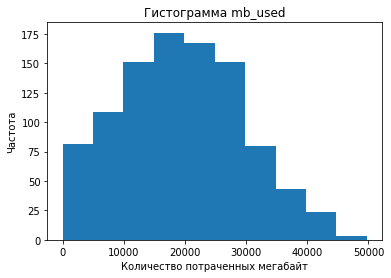

In [85]:
total_stat_ultra['mb_used'].plot(kind = 'hist')
plt.xlabel('Количество потраченных мегабайт')
plt.ylabel('Частота')
plt.title('Гистограмма mb_used')
plt.show

Визуально распределение близко к нормальному.

((0, 40000), <matplotlib.axes._subplots.AxesSubplot at 0x7f551661c3d0>)

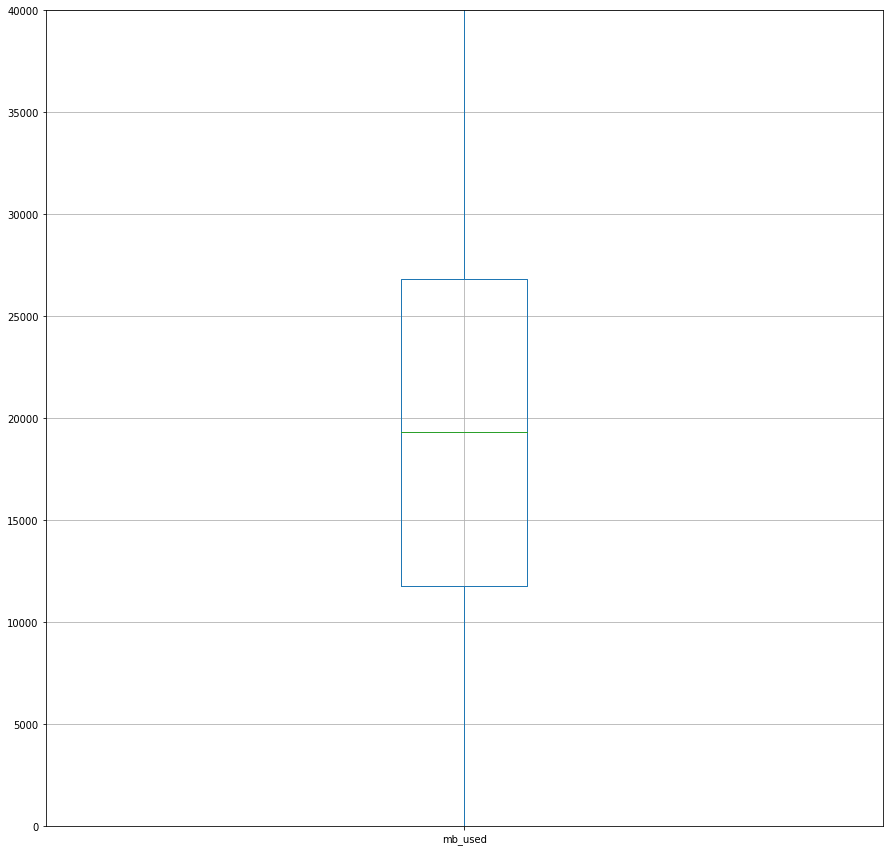

In [86]:
databox = total_stat_ultra.boxplot('mb_used', figsize = (15,15))
plt.ylim(0,40000), databox

Визуально медиана около 19000 МБ.

Также на графике видно, что границы первого и третьего квартилей не превышают лимит по тарифу (до 30720 МБ), что свидетельствует о небольшой доле пользователей, превышающих лимит тарифа по МБ. Проверим расчетами.

In [87]:
# рассчитаем среднее
print('Среднее:',round(total_stat_ultra['mb_used'].mean(), 2))

Среднее: 19469.31


In [88]:
# рассчитаем медиану
print('Медиана:',round(total_stat_ultra['mb_used'].median(), 2))

Медиана: 19309.0


Среднее незначительно смещено в сторону больших значений относительно медианы.

In [89]:
# проверим долю пользователей, которые превышают лимит интернет-трафика, заложенного в тарифе
print('Доля пользователей, превышающих лимит интернет-трафика:',\
      round(len(total_stat_ultra.query('mb_used > 30720'))*100/len(total_stat_ultra),1) ,'%')

Доля пользователей, превышающих лимит интернет-трафика: 13.6 %


In [90]:
# рассчитаем дисперсию и стандартное отклонение
variance = np.var(total_stat_ultra['mb_used'])
f'Дисперсия: {variance:.2f}, Стандартное отклонение: {np.sqrt(variance):.2f}'

'Дисперсия: 101648256.89, Стандартное отклонение: 10082.08'

Типичный пользователь данной выборки тратит 19469.31 ± 10082.08 МБ (от 9387.23 до 29551.39 МБ), что меньше лимита, установленного тарифом. Проверим.

In [91]:
print(round(len(total_stat_ultra.query('mb_used >= 9388 and mb_used <= 29552 '))*100/len(total_stat_ultra),1), '%')

66.7 %


Согласно данным представленной выборки **пользователям тарифа ultra в месяц** требуется:

* **526.62 минут** (± 317.44)    
* **49.36 сообщений** (± 47.78)     
* **19469.31 МБ** (± 10082.08)

Сравним поведение пользователей различных тарифов по основным показателям.

<function matplotlib.pyplot.show(*args, **kw)>

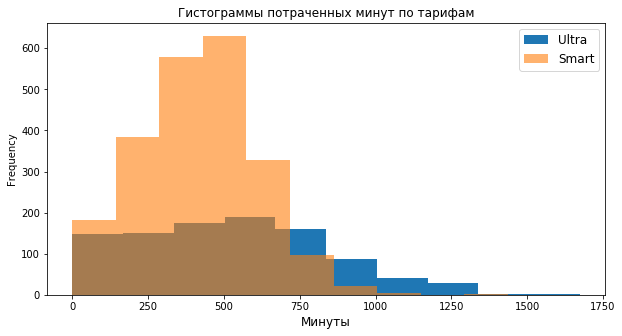

In [92]:
plt.figure(figsize=(10,5))
total_stat_ultra['calls_duration'].plot(kind = 'hist', label='Ultra')
total_stat_smart['calls_duration'].plot(kind = 'hist', label='Smart', alpha = 0.6)
plt.xlabel('Минуты', fontsize=12) 
plt.title('Гистограммы потраченных минут по тарифам')
plt.legend(fontsize=12)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

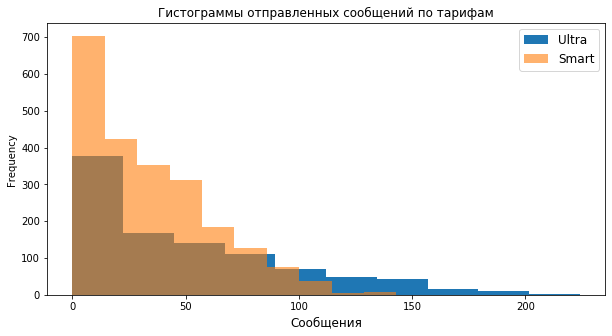

In [93]:
plt.figure(figsize=(10,5))
total_stat_ultra['messages'].plot(kind = 'hist', label='Ultra')
total_stat_smart['messages'].plot(kind = 'hist', label='Smart', alpha = 0.6)
plt.xlabel('Сообщения', fontsize=12) 
plt.title('Гистограммы отправленных сообщений по тарифам')
plt.legend(fontsize=12)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

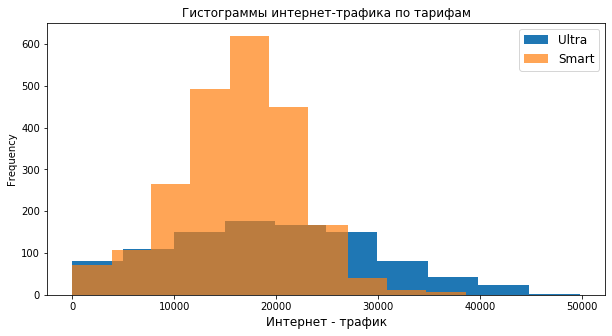

In [94]:
plt.figure(figsize=(10,5))
total_stat_ultra['mb_used'].plot(kind = 'hist', label='Ultra')
total_stat_smart['mb_used'].plot(kind = 'hist', label='Smart', alpha = 0.7)
plt.xlabel('Интернет - трафик', fontsize=12) 
plt.title('Гистограммы интернет-трафика по тарифам')
plt.legend(fontsize=12)
plt.show

Визуально на графиках видно, что пользователи тарифа Смарт ведут себя более "типично", гистограммы сконцентрированы вокруг медиан, а пользователи тарифа Ультра более "вариативны", гистограммы "растянуты" вдоль оси уникальных значений.

<function matplotlib.pyplot.show(*args, **kw)>

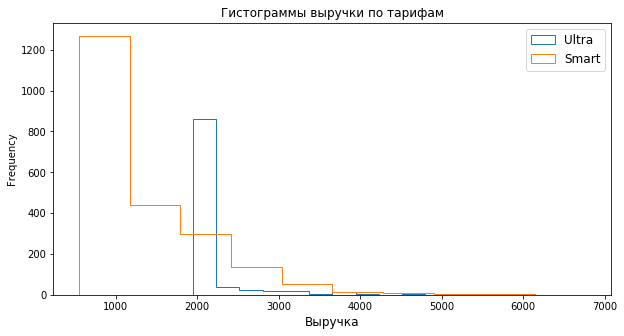

In [95]:
plt.figure(figsize=(10, 5))
total_stat_ultra['price'].plot(kind = 'hist', label='Ultra', histtype = 'step')
total_stat_smart['price'].plot(kind = 'hist', label='Smart', histtype = 'step')
plt.xlabel('Выручка', fontsize=12) 
plt.title('Гистограммы выручки по тарифам')
plt.legend(fontsize=12)
plt.show

Визуально распределения похожи, но из-за разницы размеров выборок график не очень нагляден. Но можно предположить, что выручка с пользователей тарифа Ультра выше, так как график смещен относительно графика пользователей тарифа в большую сторону. Более подробно рассмотрим выручку по разным тарифам на этапе проверки гипотез.

### Вывод

Согласно данным представленных выборок пользователям в месяц требуется:

| Smart  | std | Ultra | std|
| --- | --- | --- | --- |
| 417.93 минут| ± 190.27 | 526.62 минут| ± 317.44 |
| 33.38 сообщений| ± 28.22 | 49.36 сообщений| ± 47.78 |
| 16208.87 МБ| ± 5869.17  | 19469.31 МБ|± 10082.08 |


Из данных видно, что пользователи тарифа ультра в среднем тратят большее количество минут, сообщений и интернет-трафика.

Дисперсии:

| Smart  |var | Ultra |var |
| --- | --- | --- | --- |
| минуты| 36.203,07 | минуты | 100.771,22 |
| сообщения| 796.46 | сообщения |2282.95 |
| интернет|  34.447.101,81  | интернет |101.648.256,89 |


Согласно данным дисперсий по различным показателям обеих выборок, видно, что пользователи тарифа ультра ведут себя более "вариативно", дисперсии в разы больше аналогичных показателей для тарифа смарт, а пользователи тарифа смарт в свою очередь ведут себя более "типично".


Но несмотря на большее потребление и большую вариативность пользователей тарифа ультра, пользователи практически не превышают лимиты своего тарифа (только около 13 % в интернет-трафике). В то время как около четверти пользователей тарифа смарт превышают лимит по минутам, больше трети сообщениям, и более 58 % превышают лимит интернет-трафика.


## Проверка гипотез

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

1. Нулевая гипотеза - средняя выручка пользователей тарифов Ультра и Смарт равны.

Альтернативная гипотеза - средняя выручка пользователей тарифов Ультра и Смарт не равны.
Таким образом гипотеза двусторонняя не равны - больше или меньше.

2. Уровень значимости alpha = 0.05

3. Выборки для проверки гипотезы total_stat_ultra и total_stat_smart. Выборки независимы. 

In [96]:
print('Размеры выборок:', len(total_stat_smart['price']), 'и', len(total_stat_ultra['price']))

Размеры выборок: 2229 и 985


Можно считать их распределение нормальным, так как благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности. 

Учитывая характеристики выборок, для проверки гипотезы подойдет параметрический критерий - t-критерий Стьюдента для независимых выборок.

Так как выборки разные по размеру и при исследовании других параметров этих выборок дисперсии значительно различались, примем в качестве условия, что дисперсии выборок не равны.

In [97]:
alpha = 0.05
results = st.ttest_ind(
    total_stat_smart['price'],  
    total_stat_ultra['price'],
    equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Данные, имеющихся выборок предоставляют достаточное основание для выбранного уровня значимости отвергнуть нулевую гипотезу о равенстве выборок и принять альтернативную гипотезу об их неравенстве.

Учитывая небольшие размеры предоставленных выборок можно рассчитать среднюю выручку для каждого тарифа.

In [98]:
# средняя выручка на тарифе смарт
round(total_stat_smart['price'].mean(), 1)

1290.0

In [99]:
# средняя выручка на тарифе ультра
round(total_stat_ultra['price'].mean(), 1)

2070.2

Средняя выручка компании с выборки пользователей тарифа ультра превышает, среднюю выручку выборки пользователей с тарифа смарт.

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Добавим в датасет с группировкой по пользователям и рассчетом выручки данные о регионе пользователя

In [100]:
by_month = by_month.merge(users[['user_id', 'city']], on = ['user_id'])
by_month.head(10)

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff,message_over_tariff,mb_over_tariff,price,city
0,1000,5,17.0,159.0,22.0,2254.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
1,1000,6,28.0,172.0,60.0,23234.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
2,1000,7,41.0,340.0,75.0,14004.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
3,1000,8,42.0,408.0,81.0,14056.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
4,1000,9,46.0,466.0,57.0,14569.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
5,1000,10,44.0,350.0,73.0,14703.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
6,1000,11,37.0,338.0,58.0,14757.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
7,1000,12,38.0,333.0,70.0,9818.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
8,1001,11,45.0,430.0,0.0,18430.0,smart,0.0,0.0,3.0,1150.0,Москва
9,1001,12,47.0,414.0,0.0,14037.0,smart,0.0,0.0,0.0,550.0,Москва


Создадим отдельные датасеты для Москвы и других регионов и посчитаем среднюю выручку по пользователям.

In [101]:
stat_moscow = by_month.query('city == "Москва"')
stat_moscow.head()

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff,message_over_tariff,mb_over_tariff,price,city
8,1001,11,45.0,430.0,0.0,18430.0,smart,0.0,0.0,3.0,1150.0,Москва
9,1001,12,47.0,414.0,0.0,14037.0,smart,0.0,0.0,0.0,550.0,Москва
17,1003,8,43.0,380.0,37.0,8566.0,ultra,0.0,0.0,0.0,1950.0,Москва
18,1003,9,105.0,961.0,91.0,12469.0,ultra,0.0,0.0,0.0,1950.0,Москва
19,1003,10,97.0,855.0,83.0,14769.0,ultra,0.0,0.0,0.0,1950.0,Москва


In [102]:
stat_other = by_month.query('city not in "Москва"')
stat_other.head()

,user_id,month,calls,calls_duration,messages,mb_used,tariff,call_over_tariff,message_over_tariff,mb_over_tariff,price,city
0,1000,5,17.0,159.0,22.0,2254.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
1,1000,6,28.0,172.0,60.0,23234.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
2,1000,7,41.0,340.0,75.0,14004.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
3,1000,8,42.0,408.0,81.0,14056.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
4,1000,9,46.0,466.0,57.0,14569.0,ultra,0.0,0.0,0.0,1950.0,Краснодар


1. Нулевая гипотеза - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

Альтернативная гипотеза - средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов.
Таким образом гипотеза двусторонняя не равны - больше или меньше.

2. Уровень значимости alpha = 0.05

3. Выборки для проверки гипотезы stat_moscow и stat_other. Выборки независимы. 

In [103]:
print('Размеры выборок:', len(stat_moscow['price']), 'и', len(stat_other['price']))

Размеры выборок: 611 и 2603


Согласно ЦПТ можно считать распределение выборок нормальным.

Учитывая характеристики выборок, для проверки гипотезы подойдет параметрический критерий - t-критерий Стьюдента для независимых выборок. Выборки значимо различаются по размеру, примем в качестве условия, что дисперсии выборок не равны.

In [104]:
alpha = 0.05
results = st.ttest_ind(
    stat_moscow['price'],  
    stat_other['price'],
    equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Данные, имеющихся выборок предоставляют достаточное основание для выбранного уровня значимости принять нулевую гипотезу о равенстве выборок и отвергнуть альтернативную гипотезу об их неравенстве.

## Общий вывод

1. Согласно результатам исследования представленных выборок пользователей тарифов "Ультра"и "Смарт" их поведение различается:
* Пользователи тарифа "Ультра" в среднем тратят большее количество минут, сообщений и интернет-трафика.
* Пользователи тарифа "Ультра" ведут себя более "вариативно", дисперсии в разы больше аналогичных показателей для тарифа "Смарт", а пользователи тарифа смарт в свою очередь ведут себя более "типично".
* Пользователи тарифа "Ультра" практически не превышают лимиты своего тарифа. В то время как около четверти пользователей тарифа "Смарт" превышают лимит по минутам и сообщениям, и более 61% превышают лимит интернет-трафика.

2. Среднняя выручка пользователей Москвы и других регионов равна.

3. Средние выручки пользователей тарифов "Ультра"и "Смарт" не равны. Средняя выручка компании выборки пользователей тарифа "Ультра" превышает, среднюю выручку выборки пользователей тарифа "Смарт".

Учитывая, что коммерческий департамент хочет понять, какой тариф приносит больше денег, чтобы скорректировать рекламный бюджет, согласно данным исследования, следует выбрать тариф "Ультра".